# Run LIANA & MOFA

## Setup Env

In [1]:
import os, fnmatch

import numpy as np
import pandas as pd

import scanpy as sc
import squidpy as sq

In [2]:
import liana as li
from liana.method.sp import lr_basis, basis

In [ ]:
from mudata import MuData
import muon as mu
import mofax as mofa

In [3]:
data_dir = "/home/dbdimitrov/Repos/liana2_manuscript/data/kidney_injury/"

## Load Processed Objects

### Load Visium

In [4]:
# slides = fnmatch.filter(os.listdir(os.path.join(data_dir, 'visium', 'deconv')), '*.h5ad')
slides = fnmatch.filter(os.listdir(os.path.join(data_dir, 'visium')), '*.h5ad')

In [35]:
adatas = dict()
for slide in slides:
    # adatas[slide] = sc.read_h5ad(os.path.join(data_dir, 'visium', 'deconv', slide))
    adatas[slide] = sc.read_h5ad(os.path.join(data_dir, "visium", slide))
    sample = slide[:-5].split('_')[0]
    print(sample)
    adatas[slide].obs['sample'] = sample
    

f6wks
f12hr
f4hr
fsham
f2dps


## Run LIANA

In [54]:
lrdatas = []
for sample in adatas.keys():
    adata = adatas[sample].copy()
    
    
    sq.gr.spatial_neighbors(adata, n_rings=1, coord_type="grid", n_neighs=6)
    # TODO convert this to np.float32 internally
    
    lr_basis(adata,
            function_name="spearman",
            expr_prop=0.1,
            resource_name="MouseConsensus", 
            pvalue_method=None, 
            use_raw=False, 
            #  positive_only=True,
            proximity_key="spatial_connectivities",
            )
    # extract the local scores
    temp = li.fun.obsm_to_adata(adata, 'local_scores')
    lrdatas.append(temp)


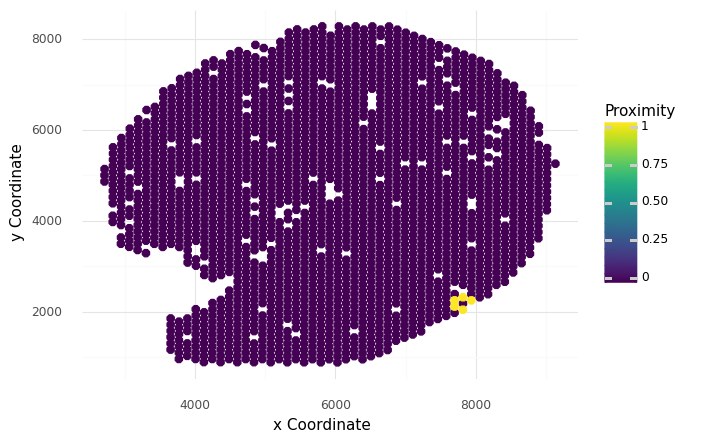

<ggplot: (8766601983748)>

In [55]:
li.pl.proximity_plot(adata, idx=1, spatial_key='spatial', proximity_key='spatial_connectivities')

In [56]:
lrdata = lrdatas[4]

In [57]:
adata.uns['global_res'].sort_values('global_mean').tail(10)

,ligand,receptor,ligand_means,ligand_props,receptor_means,receptor_props,interaction,global_mean,global_sd
98,Vim,Cd44,1.097599,0.774408,0.184779,0.266351,Vim&Cd44,0.086682,0.389365
580,Plat,Lrp1,0.648591,0.569668,0.623532,0.612322,Plat&Lrp1,0.086886,0.461606
588,Serpine2,Lrp1,0.370507,0.433649,0.623532,0.612322,Serpine2&Lrp1,0.088673,0.440651
646,Thbs1,Itga3_Itgb1,0.361685,0.435545,0.479339,0.527014,Thbs1&Itga3_Itgb1,0.099988,0.425526
154,Lgals1,Itgb1,2.485018,0.984360,1.238781,0.862085,Lgals1&Itgb1,0.132712,0.480466
1372,Agt,Lrp2,0.621692,0.603318,0.907188,0.676777,Agt&Lrp2,0.159123,0.453387
1393,Tcn2,Lrp2,1.568884,0.934597,0.907188,0.676777,Tcn2&Lrp2,0.161154,0.466413
1397,Cubn,Lrp2,0.606150,0.550237,0.907188,0.676777,Cubn&Lrp2,0.164119,0.455293
1389,Lrpap1,Lrp2,1.036744,0.822275,0.907188,0.676777,Lrpap1&Lrp2,0.172858,0.462909
845,Sparc,Eng,2.145921,0.969194,0.773470,0.716588,Sparc&Eng,0.203532,0.474326


In [58]:
# save results as modalities
local_lr  = li.fun.obsm_to_adata(adata, 'local_scores')
# local_pvals = li.fun.obsm_to_adata(adata, 'local_pvals')

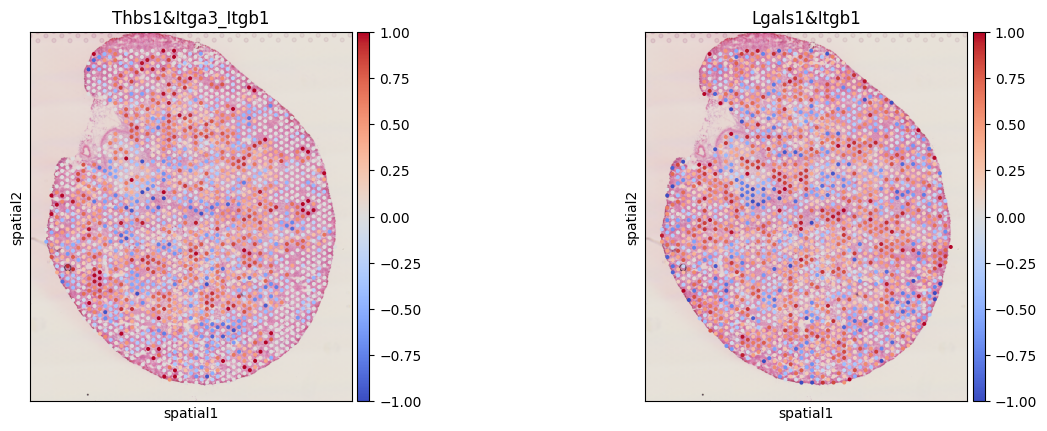

In [61]:
sc.pl.spatial(local_lr, color=['Thbs1&Itga3_Itgb1', 'Lgals1&Itgb1'], cmap='coolwarm')

## Run MOFAcell

In [111]:
adata = sc.concat(adatas=adatas)

In [124]:
mdata = li.multi.adata_to_views(adata,
                                groupby='leiden',
                                sample_key='sample',
                                obs_keys=None,
                                min_prop=0.05, # min nnz values (filter features)
                                min_smpls=3, # min samples per view (filter features)
                                min_cells=25, # min cells per view (filter samples)
                                min_counts=100, # min counts per view (filter samples)
                                mode='sum', # mode of aggregation
                                verbose=True,
                                skip_checks=True,
                                layer='counts'
                                )

100%|██████████| 6/6 [00:00<00:00,  7.43it/s]


In [126]:
for mod in mdata.mod.keys():
    sc.pp.normalize_total(mdata.mod[mod], target_sum=1e4)
    sc.pp.log1p(mdata.mod[mod])
    
    sc.pp.highly_variable_genes(mdata.mod[mod], min_mean=0.0125, max_mean=3, min_disp=0.5)

In [130]:
model = mu.tl.mofa(mdata, 
                   use_obs='union',
                   convergence_mode='medium',
                   outfile="models/lrs.hdf5",
                   n_factors=5,
                   use_var='highly_variable'
                   )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='4' group='group1' with N=5 samples and D=7741 features...
Loaded view='1' group='group1' with N=5 samples and D=9674 features...
Loaded view='3' group='group1' with N=5 samples and D=10690 features...
Loaded view='2' group='group1' with N=5 samples and D=10374 features...
Loaded view='0' group='group1' with N=5 samples and D=8821 features...
Loaded view='5' group='g

In [131]:
# obtain factor scores
factor_scores = li.multi.get_factor_scores(mdata, obsm_key='X_mofa')
factor_scores.head()


,index,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,f12hr,-0.003691,-5.648298e-273,-1.115642e-272,-6.124810e-273,8.617000e-239
1,f2dps,-0.014354,-1.198696e-273,-2.363032e-273,-1.300179e-273,1.870655e-239
2,f4hr,0.044045,4.062491e-274,8.032608e-274,4.410250e-274,-7.866098e-240
3,f6wks,-0.023065,2.135028e-273,4.191931e-273,2.315748e-273,-3.650413e-239
4,fsham,-0.007197,4.259096e-273,8.431729e-273,4.617646e-273,-5.979658e-239


## Run MOFA

In [90]:
lrdata = sc.concat(lrdatas, join='outer', fill_value=0)

In [99]:
lrdata.obs['group'] = lrdata.obs['sample'].str.split('_').str[0]

In [103]:
mdata = li.multi.adata_to_views(lrdata,
                                groupby='leiden',
                                sample_key='sample',
                                obs_keys=['group'],
                                min_prop=0.05, # min nnz values (filter features)
                                min_smpls=3, # min samples per view (filter features)
                                min_cells=25, # min cells per view (filter samples)
                                min_counts=0, # min counts per view (filter samples)
                                mode='mean', # mode of aggregation
                                verbose=True,
                                skip_checks=True
                                )

100%|██████████| 6/6 [00:00<00:00, 17.43it/s]


In [108]:
mdata

MuData object with n_obs × n_vars = 5 × 3137
  obs:	'group'
  obsm:	'X_mofa'
  varm:	'LFs'
  6 modalities
    4:	4 x 462
      layers:	'psbulk_props'
    1:	5 x 553
      layers:	'psbulk_props'
    3:	5 x 554
      layers:	'psbulk_props'
    2:	5 x 554
      layers:	'psbulk_props'
    0:	5 x 552
      layers:	'psbulk_props'
    5:	2 x 462
      layers:	'psbulk_props'

In [106]:
model = mu.tl.mofa(mdata, 
                   use_obs='union',
                   convergence_mode='medium',
                   outfile="models/lrs.hdf5",
                   n_factors=5
                   )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='4' group='group1' with N=5 samples and D=462 features...
Loaded view='1' group='group1' with N=5 samples and D=553 features...
Loaded view='3' group='group1' with N=5 samples and D=554 features...
Loaded view='2' group='group1' with N=5 samples and D=554 features...
Loaded view='0' group='group1' with N=5 samples and D=552 features...
Loaded view='5' group='group1' 

In [107]:
# obtain factor scores
factor_scores = li.multi.get_factor_scores(mdata, obsm_key='X_mofa')
factor_scores.head()


,sample,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,group
0,f12hr,2.394882e-25,-2.166753e-26,-2.122556e-25,3.639084e-25,-5.843056e-23,f12hr
1,f2dps,9.300038e-26,-8.967082e-27,-7.961802e-26,1.486270e-25,-2.409054e-23,f2dps
2,f4hr,2.343375e-25,-2.115075e-26,-2.072559e-25,3.577244e-25,-5.722538e-23,f4hr
3,f6wks,-6.932542e-25,6.296980e-26,6.108462e-25,-1.061783e-24,1.698516e-22,f6wks
4,fsham,1.307431e-25,-1.157203e-26,-1.155009e-25,1.980263e-25,-3.119185e-23,fsham
